# Исследование объявлений о продаже квартир
Архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
houses = pd.read_csv(r'C:\Users\Sergl\OneDrive\Рабочий стол\real_estate_data.csv', sep = '\t')
pd.set_option('display.max_columns', None)
houses.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   



 **Первоначальные данные, оказались не очень радостными. По многим параметрам люди забывали указывать информацию. Удивительным фактом для меня стало, что многие не указали наличие прудов, парков рядом с квартиров, видимо это связанно с тем что их попросту близко нет. В данных присутствовали квартиры, очень близко к аэропотру, что тоже в реальной жизни редко всретишь, видимо произошла какая то ошибка при заполнении. Так же многие люди забывали заполнить данные про апартаменты, видимо была человеческая ошибка. У многих квартир отсутствует срок размещения объявления, видимо такие квартиры еще не продались. В названии населенных пунктов всречаются много дубликатов, которые довольно сложно выявить, нужно унифицировать форма вводу записей населенный пунктов в дальнейшем, чтобы проблем не возникало. Если в квартире отсутсвтует балкон, многие забывали указывать это. Некотрые квартиры имеют слишком нереальную высоту потолков, видимо такие выбросы связанны с ошибкой внесениия данных. Дату размещения объявления почему то оказалась объектов, а не датой.**


### Предобработка данных

In [4]:
houses = houses.drop_duplicates()
houses.dropna(subset = ['floors_total'], inplace = True)
houses['locality_name'] = houses['locality_name'].astype(object)
houses.dropna(subset = ['locality_name'], inplace = True)
houses['first_day_exposition'] = pd.to_datetime(houses['first_day_exposition'], format = '%Y-%m-%d %H:%M')

In [5]:
houses['is_apartment'].fillna(False, inplace = True)

houses['is_apartment'] = houses['is_apartment'].astype('bool')


#### В столбце апартаменты всречались 3 разных поля, значение nan скорее всего заполняли у кого не апартаменты, тем самым мы поменяли на False  и преобразовали данные в булевый тип

In [6]:
houses['balcony'].unique()
houses['balcony'].fillna(0, inplace = True)
houses['balcony'] = houses['balcony'].astype('int64')

#### с балконами похожая ситуация если присутсвуют пропуски скорее всего у квартрир нет балконов, и переведем в целое число колличество балконов

In [7]:
display(houses['parks_nearest'].isna().sum())
houses['ponds_nearest'].isna().sum()

15535

14529

#### сложно сказать что делать с такими пропусками, их очень много и удалять или чем то заполнять не логично, стоит отсавить их без изменения

In [8]:
houses['ceiling_height'].fillna(houses['ceiling_height'].median(), inplace = True)
houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony         

In [9]:
houses.rename(columns = {'cityCenters_nearest' : 'city_centers_nearest'}, inplace = True) # Сделаем змеиную запись

#### Заполню пропуски в высоте этажей медианным значеним остальных данных

In [10]:
#houses['rooms'].unique()
houses['total_area'].median()
houses.query('rooms == 0 and (studio == False and  total_area > 50)') 
houses.loc[(houses['rooms'] == 0) & (houses['studio'] == False), 'rooms'] = 1

#### Анализ выявил квартиры с 0 комнатами, сравним со студиями появилось что часть из этих квартир не являются студиями но с маленькой площадью, получилось выявить 1 квартиру с большей площадью. ТАк же логично такие квартиры заменить на однокомнатные

In [11]:
houses['living_area'].fillna(houses['living_area'].median(), inplace = True)
houses['kitchen_area'].fillna(houses['kitchen_area'].median(), inplace = True)

In [12]:
houses['locality_name'] = houses['locality_name'].str.lower()
houses['locality_name'] = houses['locality_name'].str.replace('посёлок', 'поселок')
houses['locality_name'] = houses['locality_name'].str.replace('городской поселок', 'поселок городского типа')


houses['locality_name'].unique().shape[0] # уникальные значения

323

In [13]:
houses = houses.query('last_price< 10000000')
houses = houses.query('total_area < 125')
houses = houses.query('ceiling_height>2.5')
houses.update(houses[(houses['ceiling_height'] >= 25) & (houses['ceiling_height'] <= 55)]['ceiling_height']/10)
houses = houses.query('ceiling_height < 5.5')
houses = houses.query('floors_total < 29')
houses = houses.query('living_area > 10 and living_area <190')
houses = houses.query('kitchen_area <60')
houses = houses.query('days_exposition < 365*3.5')
houses = houses.query('airports_nearest > 7000')

#### Анализ гистограмм показал что некоторые выбросы помешают определить правильность исследования. Их стоит удалить. 1) Удалим аномальные значения в стоимости квартиры свыше 100.000.000 млн. очень выделяются квартиры. 2) жилая площадь более 125 кв.м нехарктерна для этого региона и ее тоже нужно удалить. 3) высоту потолков привели к правильным значением поделив выбросы на 10, те потолки которые ниже 2.5 метров являются невозможными и возможно тут ошибка при занесении данных, так же высота потолков свыше 5.5 нехарктерна для обычных домовой, они тут будут выбросами удалим их! 4) количество этажей больше 29 тоже являются выбросами и портят картину. 5) с Живой площадью и кухонной площадью поступим так же. 5) Кол-во дней обращения я считаю не актуальным свыше 3 лет, в нашем случае удалим те объявления которые провесели свыше 3.5 лет и являются выбросами. 6) удалим те дома которые ближе к аэропорту на 7 км. это недопустимо и кол-во таких мало, что уже радует)  

In [14]:
houses.reset_index(drop = True, inplace = True) # Сделаем новые индексы

### Посчитайте и добавьте в таблицу стоимость кв.м., день и месяц объявления

In [15]:
houses['cost_for_1m'] = houses['last_price']/houses['total_area']
houses.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_for_1m
0,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079
1,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286
2,6,3700000.0,37.3,2017-11-02,1,2.65,26.0,10.6,6,False,False,False,14.4,1,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456
3,5,5050000.0,39.6,2017-11-16,1,2.67,12.0,20.3,3,False,False,False,8.5,0,санкт-петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,127525.252525
4,9,3300000.0,44.0,2018-08-27,2,2.65,5.0,31.0,4,False,False,False,6.0,1,ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0,75000.000000


In [16]:
houses['week_day_of_exposition'] = pd.DatetimeIndex(houses['first_day_exposition']).dayofweek
houses.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_for_1m,week_day_of_exposition
0,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1
1,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3
2,6,3700000.0,37.3,2017-11-02,1,2.65,26.0,10.6,6,False,False,False,14.4,1,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456,3
3,5,5050000.0,39.6,2017-11-16,1,2.67,12.0,20.3,3,False,False,False,8.5,0,санкт-петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,127525.252525,3
4,9,3300000.0,44.0,2018-08-27,2,2.65,5.0,31.0,4,False,False,False,6.0,1,ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0,75000.000000,0


In [17]:
houses['month_of_exposition'] = pd.DatetimeIndex(houses['first_day_exposition']).month
houses.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_for_1m,week_day_of_exposition,month_of_exposition
0,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12
1,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8
2,6,3700000.0,37.3,2017-11-02,1,2.65,26.0,10.6,6,False,False,False,14.4,1,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456,3,11
3,5,5050000.0,39.6,2017-11-16,1,2.67,12.0,20.3,3,False,False,False,8.5,0,санкт-петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,127525.252525,3,11
4,9,3300000.0,44.0,2018-08-27,2,2.65,5.0,31.0,4,False,False,False,6.0,1,ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0,75000.000000,0,8


In [18]:
houses['year_of_exposition'] = pd.DatetimeIndex(houses['first_day_exposition']).year
houses.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_for_1m,week_day_of_exposition,month_of_exposition,year_of_exposition
0,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018
1,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015
2,6,3700000.0,37.3,2017-11-02,1,2.65,26.0,10.6,6,False,False,False,14.4,1,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456,3,11,2017
3,5,5050000.0,39.6,2017-11-16,1,2.67,12.0,20.3,3,False,False,False,8.5,0,санкт-петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,127525.252525,3,11,2017
4,9,3300000.0,44.0,2018-08-27,2,2.65,5.0,31.0,4,False,False,False,6.0,1,ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0,75000.000000,0,8,2018


In [19]:
def type_floor(leng): # Определим этаж
    total_floor = leng['floors_total']
    floor = leng['floor']
    if floor ==1:
        return 'первый'
    elif floor == total_floor:
        return 'последний'
    else:
        return 'другой'
houses['type_floor'] = houses.apply(type_floor, axis = 1)
houses.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_for_1m,week_day_of_exposition,month_of_exposition,year_of_exposition,type_floor
0,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый
1,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой
2,6,3700000.0,37.3,2017-11-02,1,2.65,26.0,10.6,6,False,False,False,14.4,1,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,другой
3,5,5050000.0,39.6,2017-11-16,1,2.67,12.0,20.3,3,False,False,False,8.5,0,санкт-петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,127525.252525,3,11,2017,другой
4,9,3300000.0,44.0,2018-08-27,2,2.65,5.0,31.0,4,False,False,False,6.0,1,ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0,75000.000000,0,8,2018,другой
5,20,3550000.0,42.8,2017-07-01,2,2.56,5.0,27.0,5,False,False,False,5.2,1,петергоф,37868.0,33058.0,1.0,294.0,3.0,298.0,366.0,82943.925234,5,7,2017,последний
6,1,4400000.0,36.0,2016-06-23,1,2.65,6.0,17.0,1,False,False,False,8.0,0,пушкин,20782.0,30759.0,0.0,NaN,1.0,96.0,203.0,122222.222222,3,6,2016,первый
7,16,4650000.0,39.0,2017-11-18,1,2.65,14.0,20.5,5,False,False,False,7.6,1,санкт-петербург,12900.0,14259.0,1.0,590.0,1.0,296.0,19.0,119230.769231,5,11,2017,другой
8,11,6700000.0,82.0,2017-11-23,3,3.05,5.0,55.6,1,False,False,False,9.0,0,санкт-петербург,22108.0,10698.0,3.0,420.0,0.0,NaN,397.0,81707.317073,3,11,2017,первый
9,6,4180000.0,36.0,2016-09-09,1,2.65,17.0,16.5,7,False,False,False,11.0,1,санкт-петербург,33564.0,14616.0,0.0,NaN,1.0,859.0,571.0,116111.111111,4,9,2016,другой


In [20]:
houses['distance_to_center_in_km'] = round(houses['city_centers_nearest']/1000)
try:
       houses['distance_to_center_in_km'] = houses['distance_to_center_in_km'].astype('int64') 
except:
        print('Error, round is not so good')
houses.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_for_1m,week_day_of_exposition,month_of_exposition,year_of_exposition,type_floor,distance_to_center_in_km
0,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,19
1,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14
2,6,3700000.0,37.3,2017-11-02,1,2.65,26.0,10.6,6,False,False,False,14.4,1,поселок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,другой,19
3,5,5050000.0,39.6,2017-11-16,1,2.67,12.0,20.3,3,False,False,False,8.5,0,санкт-петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,127525.252525,3,11,2017,другой,14
4,9,3300000.0,44.0,2018-08-27,2,2.65,5.0,31.0,4,False,False,False,6.0,1,ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0,75000.000000,0,8,2018,другой,52


### Проведите исследовательский анализ данных

{'whiskers': [<matplotlib.lines.Line2D at 0x1872878f160>,
 'caps': [<matplotlib.lines.Line2D at 0x1872878f580>,
 'boxes': [<matplotlib.lines.Line2D at 0x1872878eec0>],
 'medians': [<matplotlib.lines.Line2D at 0x1872878fac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1872878fd60>],
 'means': []}

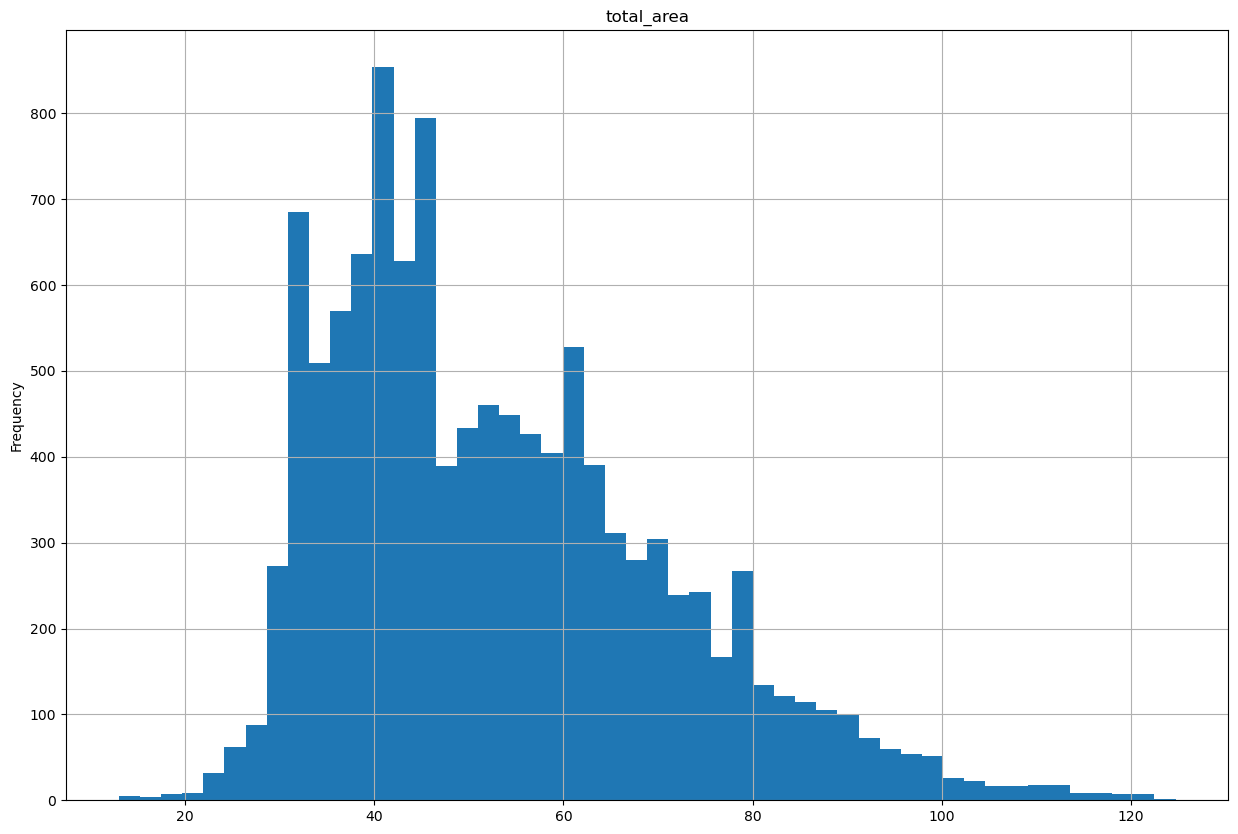

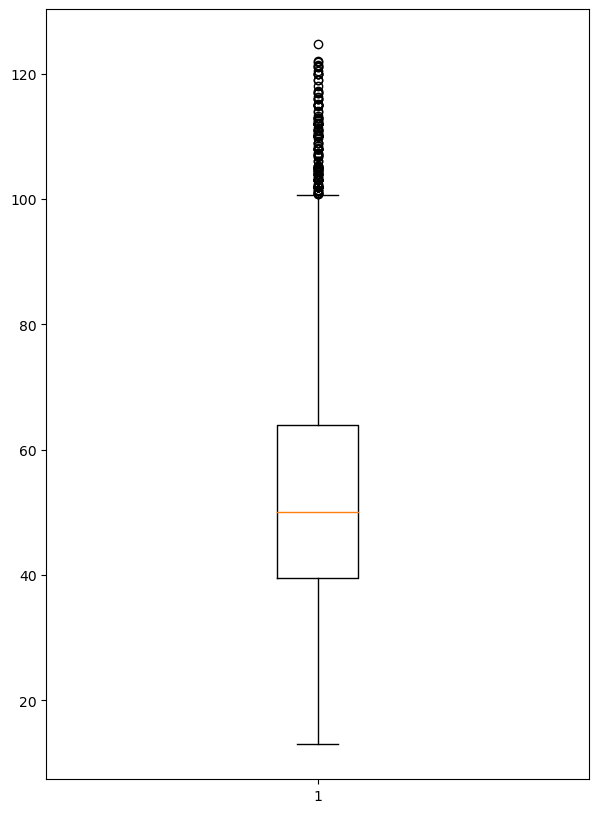

In [21]:
houses['total_area'].plot(kind = 'hist', bins = 50, figsize = (15,10), grid = True, title = 'total_area')

fig = plt.figure(figsize =(7, 10))
plt.boxplot(houses['total_area'])

#### В приниципе площади квартир распределились равномерно, не наблюдается особо огромных квартрит, однако существуют и довольно малые квартиры(сейчас тенденция на уменьшение жилой площади, так что такое скорее всего вероятный исход) Построим "усы" для проверки нашего предположения, на них видно что часть квартир все таки выделяется от общего числа

{'whiskers': [<matplotlib.lines.Line2D at 0x1872798d6c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1872798dae0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1872798d420>],
 'medians': [<matplotlib.lines.Line2D at 0x1872798e020>],
 'fliers': [<matplotlib.lines.Line2D at 0x1872798e2c0>],
 'means': []}

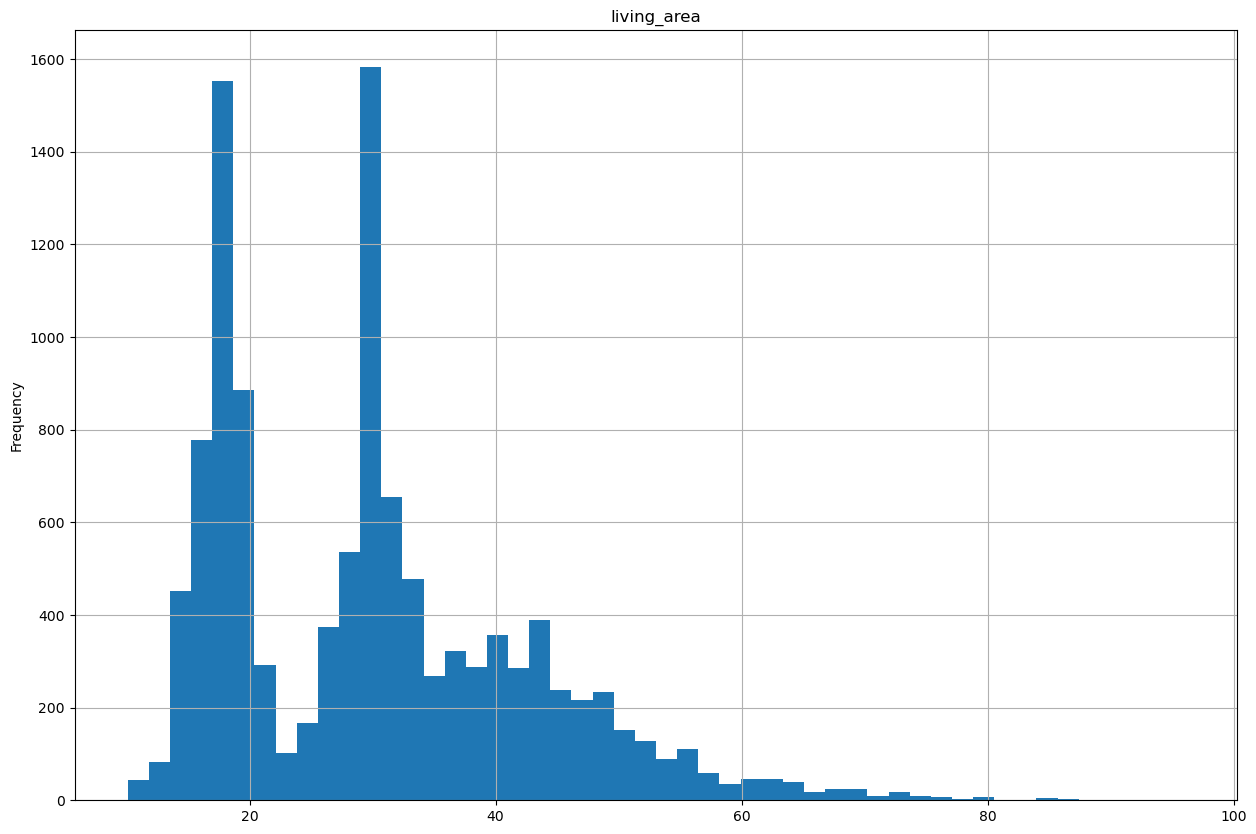

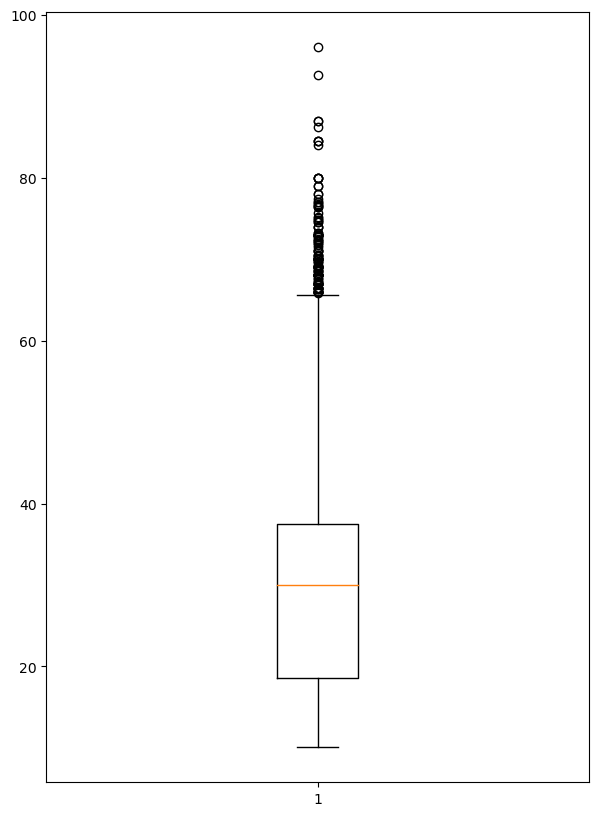

In [22]:
houses['living_area'].plot(kind = 'hist', bins = 50, figsize = (15,10), grid = True, title = 'living_area')

fig = plt.figure(figsize =(7, 10))
plt.boxplot(houses['living_area'])

#### Тут видны пики по популярности квартир. Наиболее распространенные квартиры с площадью жилой 17 и 30 кв.м. Однако все равно не совсем понятно почему между этими значениями наблюдается такое падение.

{'whiskers': [<matplotlib.lines.Line2D at 0x18728614460>,
 'caps': [<matplotlib.lines.Line2D at 0x187286149a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x187286141c0>],
 'medians': [<matplotlib.lines.Line2D at 0x18728614ee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x18728615180>],
 'means': []}

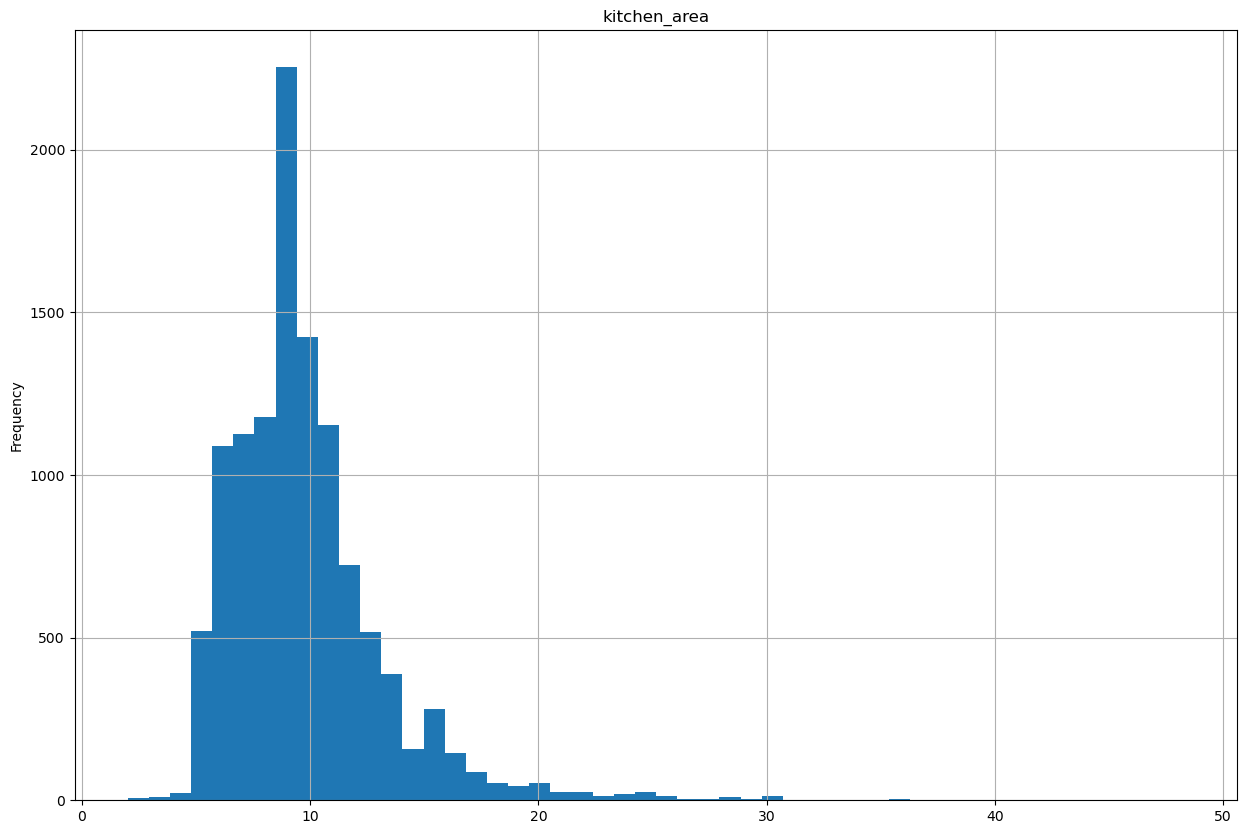

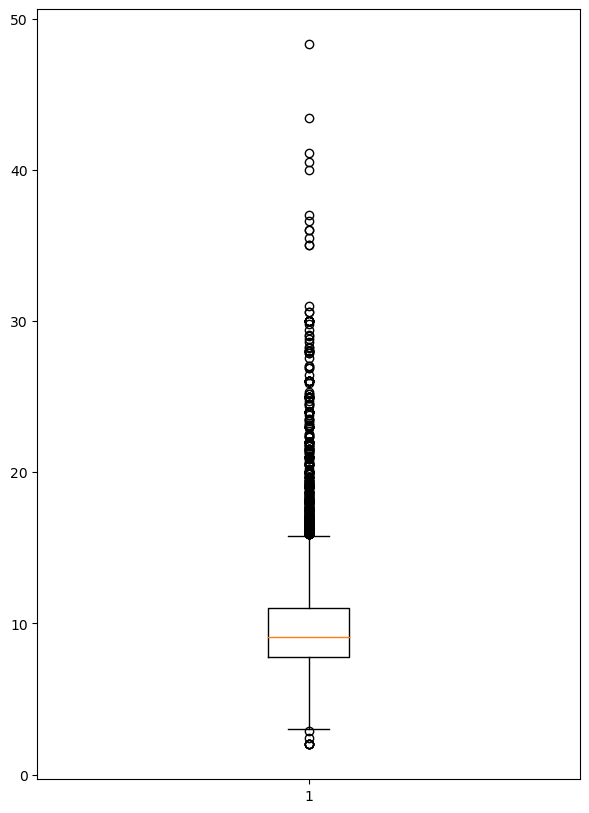

In [23]:
houses['kitchen_area'].plot(kind = 'hist', bins = 50, figsize = (15,10), grid = True, title = 'kitchen_area')

fig = plt.figure(figsize =(7, 10))
plt.boxplot(houses['kitchen_area'])

{'whiskers': [<matplotlib.lines.Line2D at 0x18727940d00>,
 'caps': [<matplotlib.lines.Line2D at 0x187279413c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18727940cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x187279418d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x187279418a0>],
 'means': []}

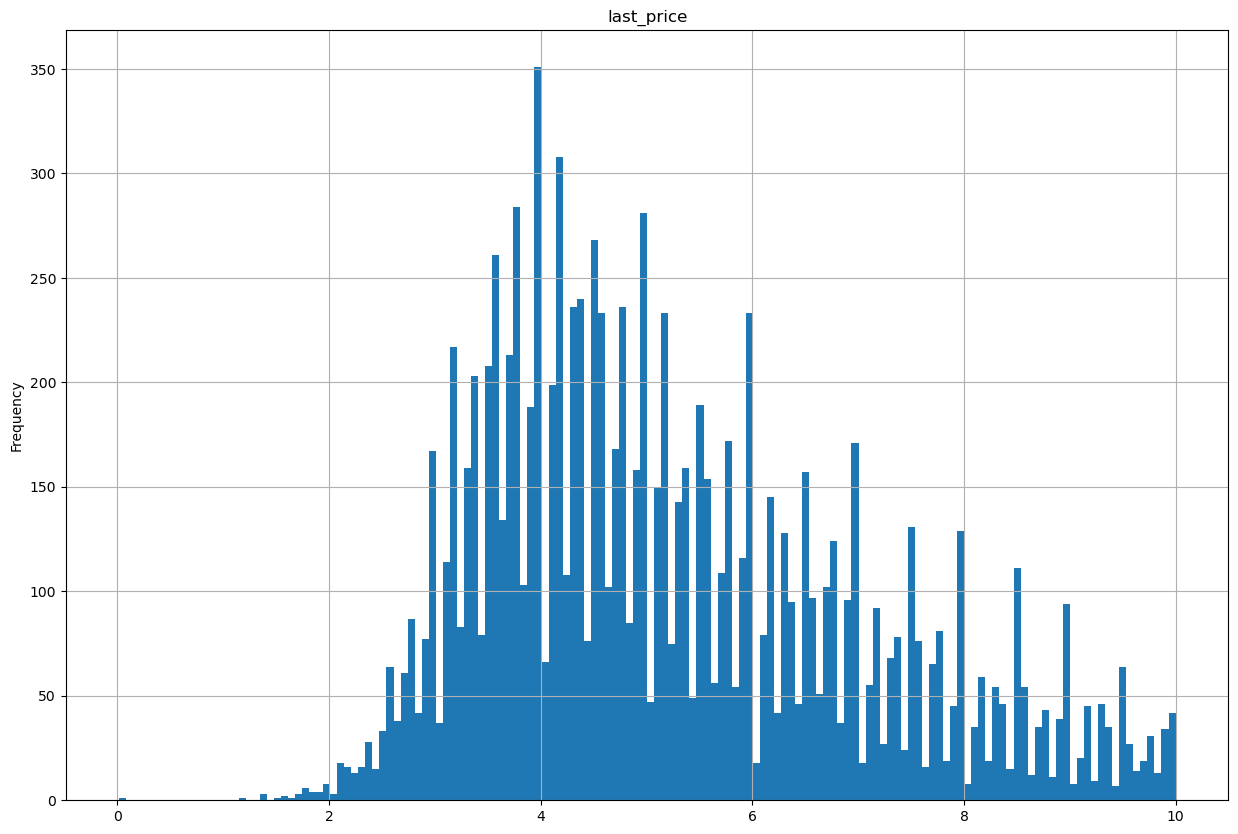

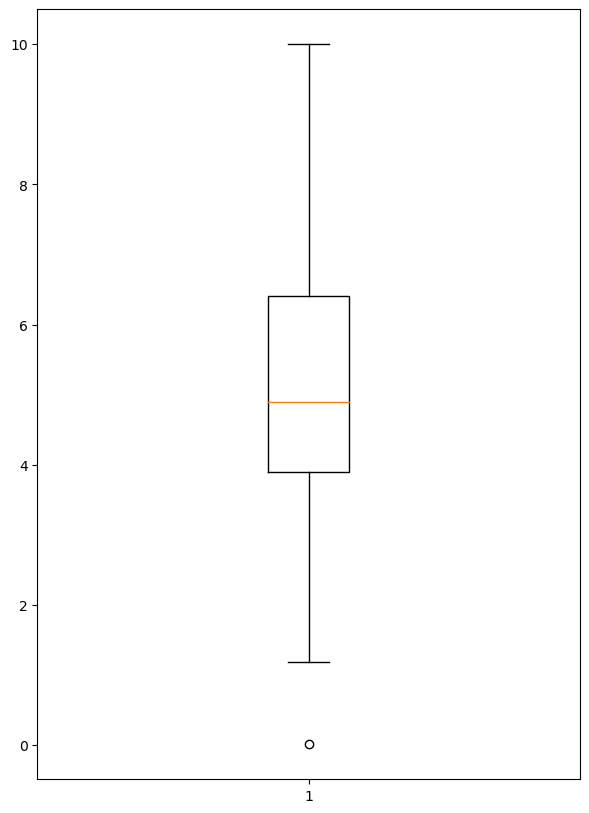

In [24]:
houses['last_price'] = houses['last_price']/1000000
houses['last_price'].plot(kind = 'hist', bins = 150, figsize = (15,10), grid = True, title = 'last_price')

fig = plt.figure(figsize =(7, 10))
plt.boxplot(houses['last_price'])

#### Стоимость жилья выглядит логично, присутсвует 1 очень дешевая квартира, остальные в рыночном диапазоне,наблюдается элитная недвижимость стоящая дороже обыкновенной, она находится справа от основной массы.

{'whiskers': [<matplotlib.lines.Line2D at 0x18727d62080>,
 'caps': [<matplotlib.lines.Line2D at 0x18727d63af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18727d62e60>],
 'medians': [<matplotlib.lines.Line2D at 0x18727d61db0>],
 'fliers': [<matplotlib.lines.Line2D at 0x18727d61d80>],
 'means': []}

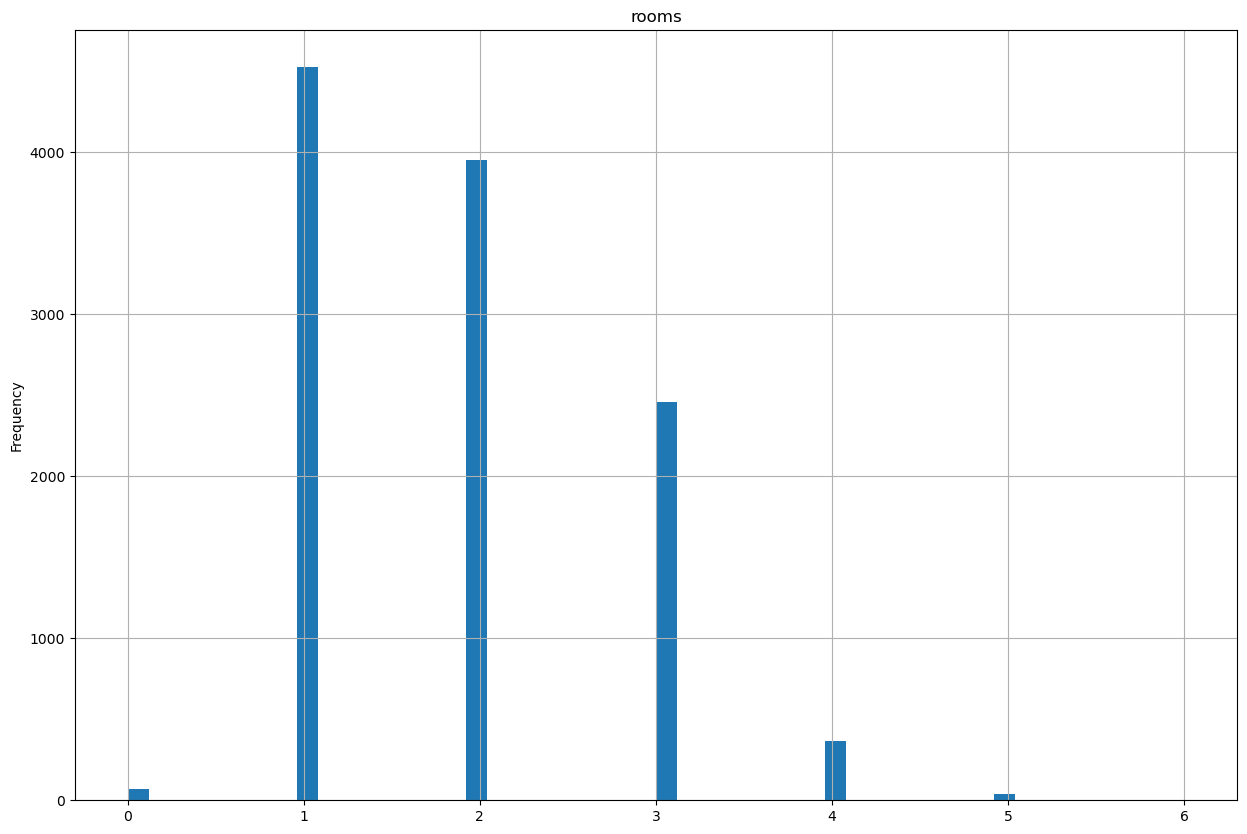

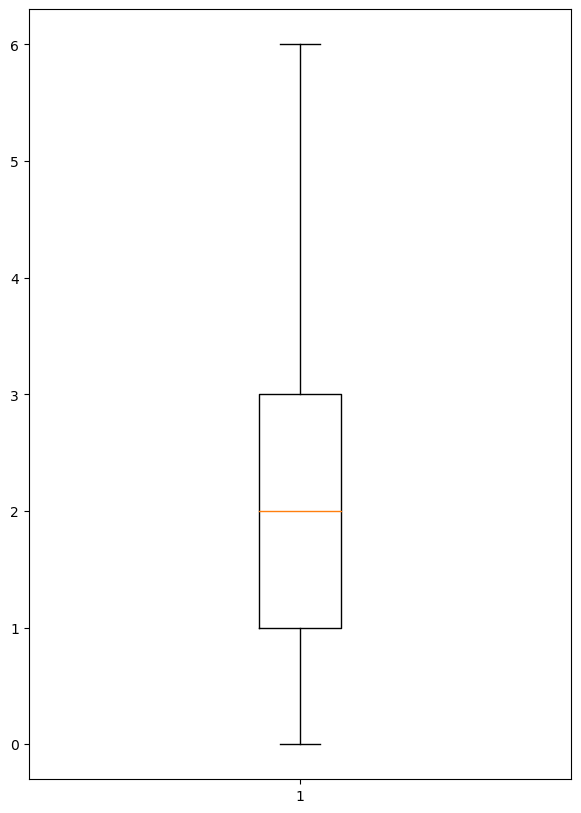

In [25]:
houses['rooms'].plot(kind = 'hist', bins = 50, figsize = (15,10), grid = True, title = 'rooms')

fig = plt.figure(figsize =(7, 10))
plt.boxplot(houses['rooms'])

#### С этим показателем в принципе тоже все понятно и логично, преобладают квартиры с 1,2 комнатами, что очевидно

{'whiskers': [<matplotlib.lines.Line2D at 0x18729a6a9b0>,
 'caps': [<matplotlib.lines.Line2D at 0x18729a6aef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18729a6a710>],
 'medians': [<matplotlib.lines.Line2D at 0x18729a6b430>],
 'fliers': [<matplotlib.lines.Line2D at 0x18729a6b6d0>],
 'means': []}

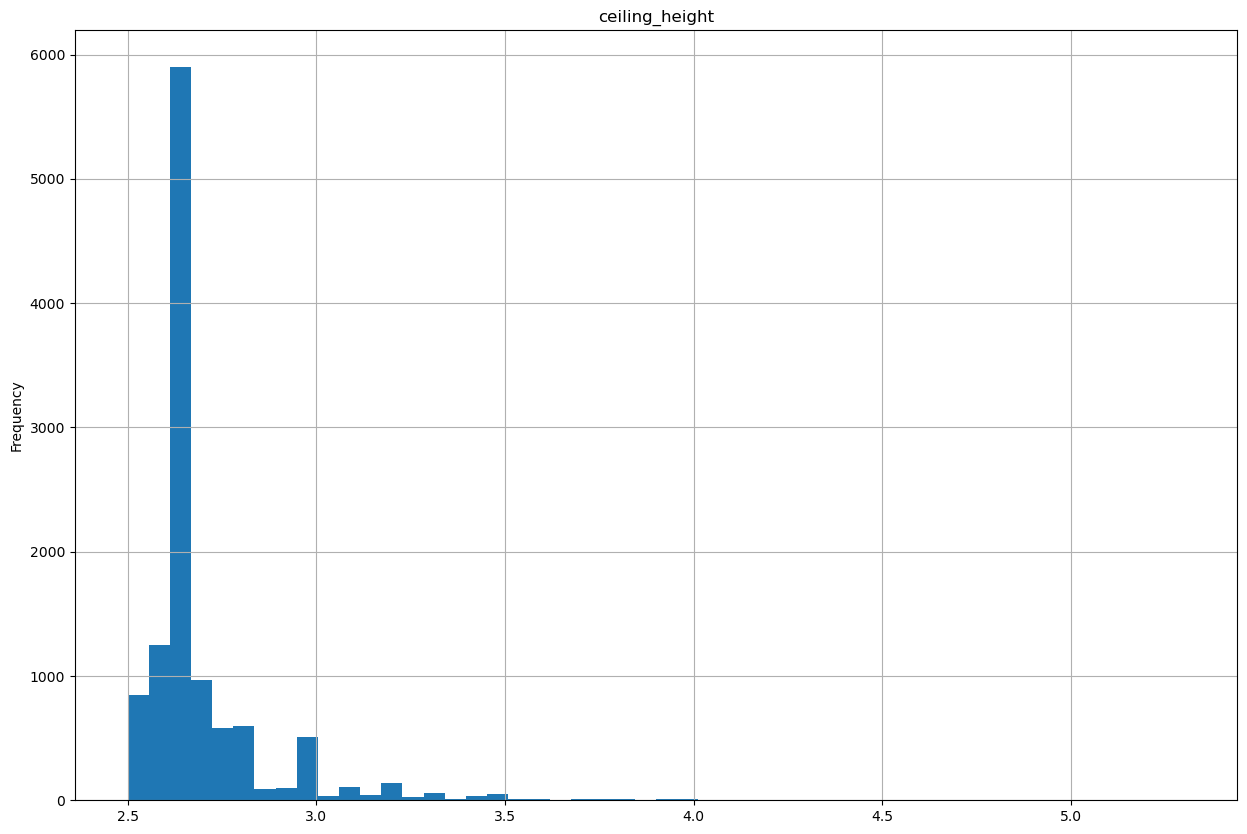

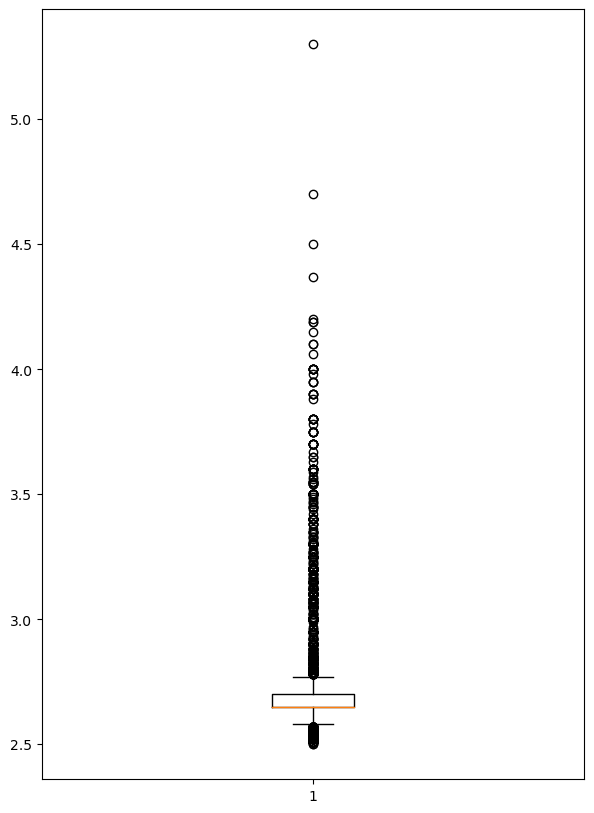

In [26]:
houses['ceiling_height'].plot(kind = 'hist', bins = 50, figsize = (15,10), grid = True, title = 'ceiling_height')

fig = plt.figure(figsize =(7, 10))
plt.boxplot(houses['ceiling_height'])

#### Судя по всему почти все дома строились по одним и тем же ГОСТам и уровень потолков у всех почти одинаковый

{'whiskers': [<matplotlib.lines.Line2D at 0x18729dacf70>,
 'caps': [<matplotlib.lines.Line2D at 0x18729dad390>,
 'boxes': [<matplotlib.lines.Line2D at 0x18729daccd0>],
 'medians': [<matplotlib.lines.Line2D at 0x18729dad8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x18729dadb70>],
 'means': []}

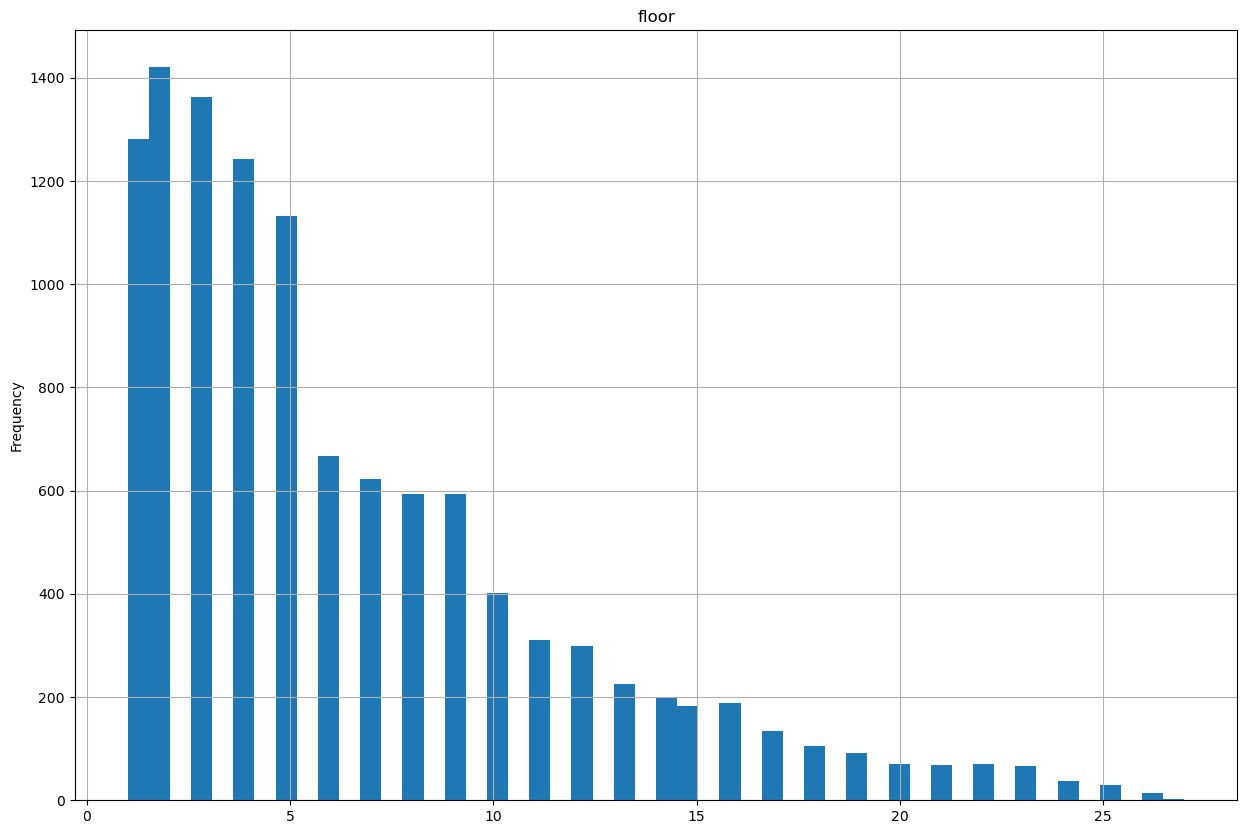

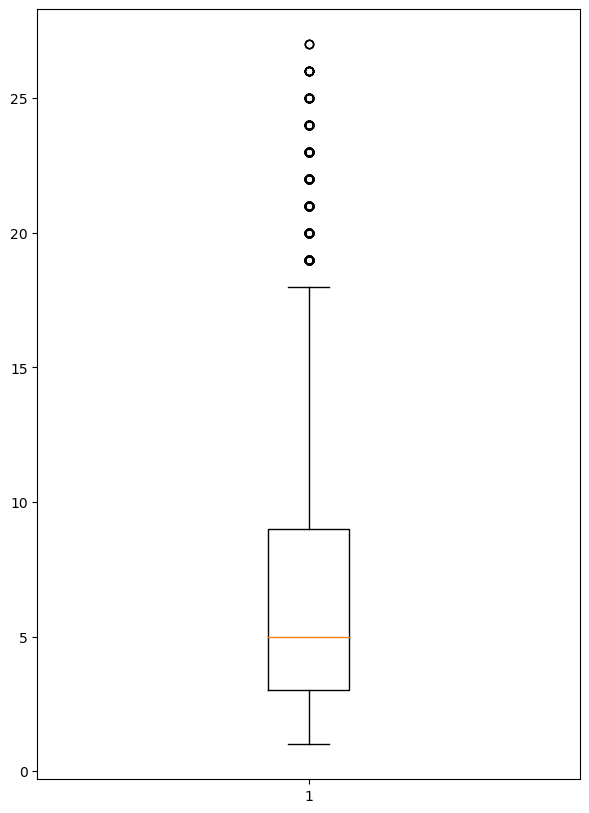

In [27]:
houses['floor'].plot(kind = 'hist', bins = 50, figsize = (15,10), grid = True, title = 'floor')

fig = plt.figure(figsize =(7, 10))
plt.boxplot(houses['floor'])

#### Для России это картина очевидная, не беря Москву, большинство домов имеют мало этажей, поэтому и большинсво квартир лежат в диапазоне от 1 по 5 этаж

{'whiskers': [<matplotlib.lines.Line2D at 0x1872af5fd60>,
 'caps': [<matplotlib.lines.Line2D at 0x1872af902e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1872af5fac0>],
 'medians': [<matplotlib.lines.Line2D at 0x1872af90820>],
 'fliers': [<matplotlib.lines.Line2D at 0x1872af90ac0>],
 'means': []}

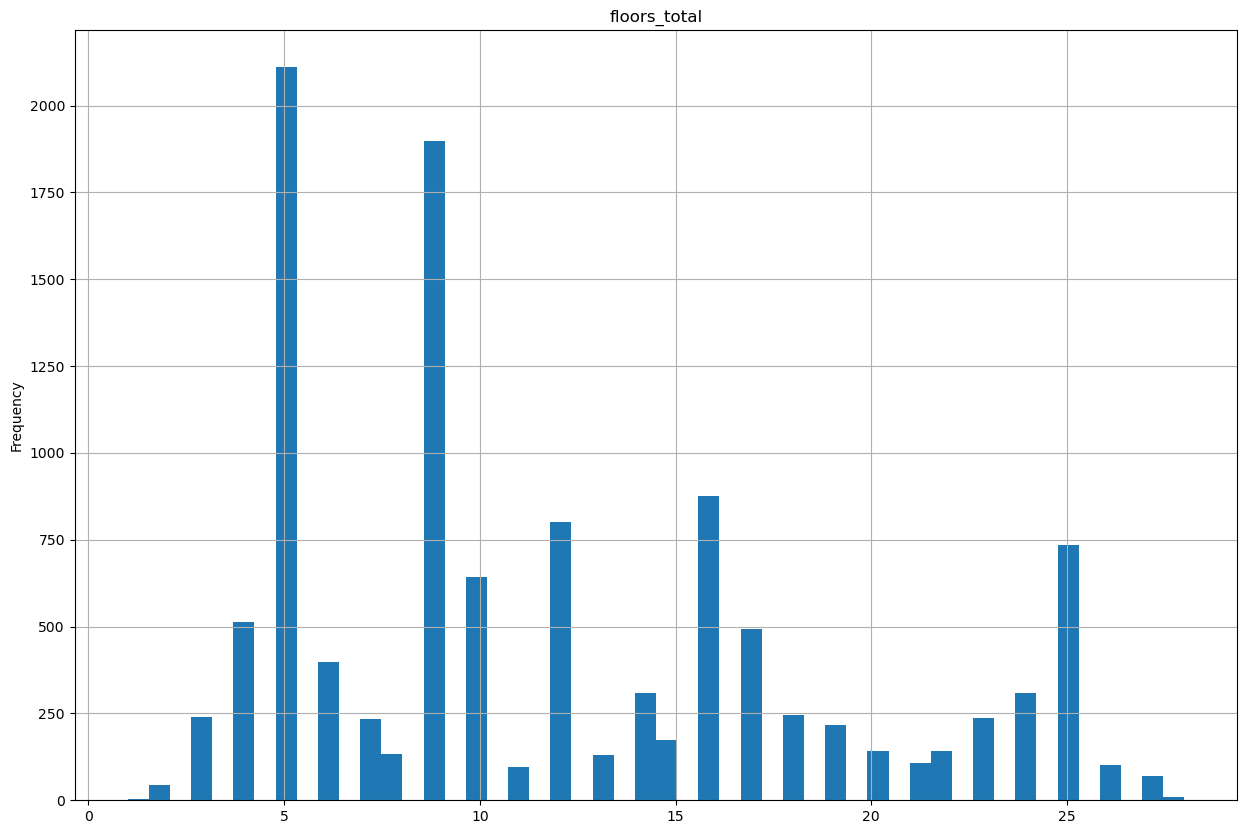

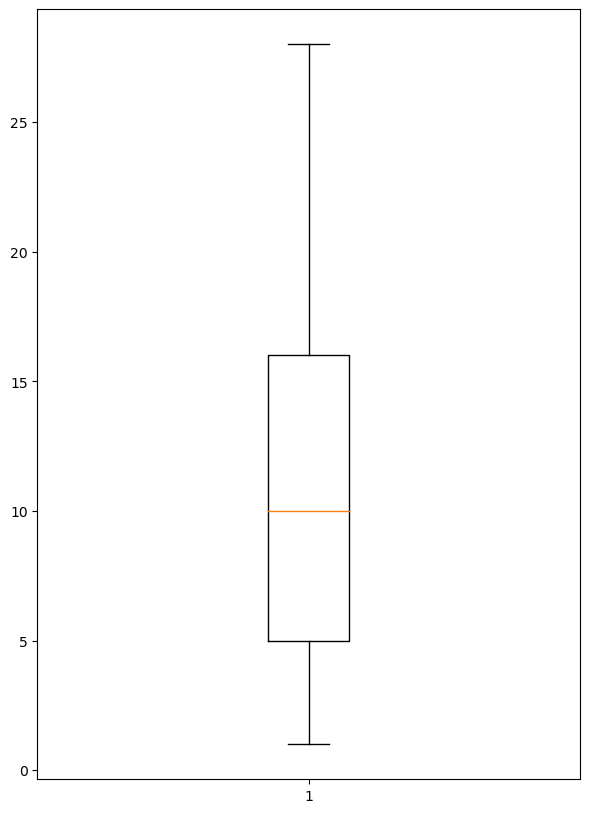

In [28]:
houses['floors_total'].plot(kind = 'hist', bins = 50, figsize = (15,10), grid = True, title = 'floors_total')

fig = plt.figure(figsize =(7, 10))
plt.boxplot(houses['floors_total'])

#### 5 и 9 этажные здания самые популярные в России и не удивитиельно, что они будут лидировать и тут)

<Axes: title={'center': 'type_floor'}, ylabel='type_floor'>

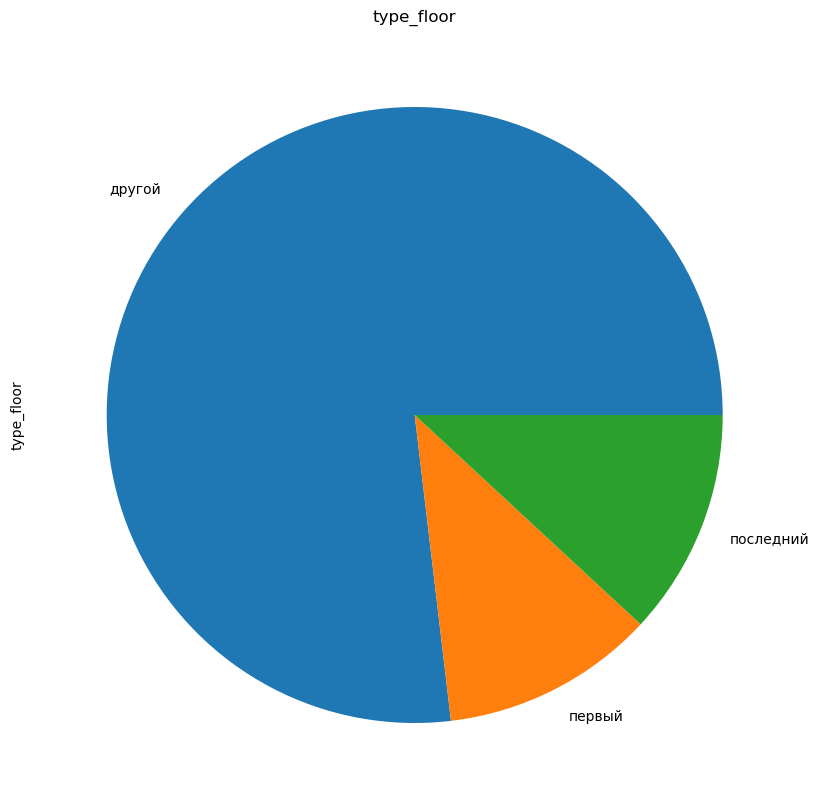

In [29]:
houses.groupby('type_floor')['type_floor'].count().plot(kind = 'pie', figsize = (15,10), title = 'type_floor')

<Axes: title={'center': 'week_day_of_exposition'}, ylabel='Frequency'>

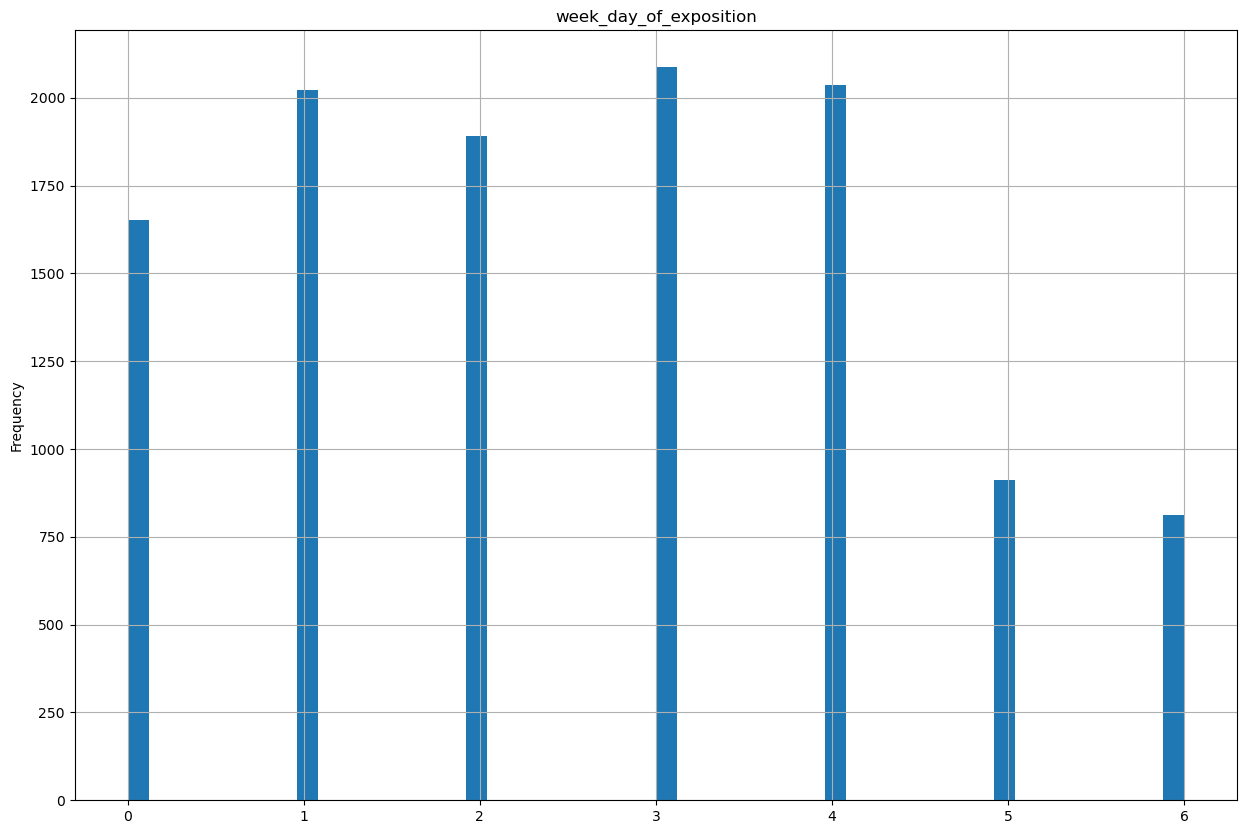

In [30]:
houses['week_day_of_exposition'].plot(kind = 'hist', bins = 50, figsize = (15,10), grid = True, title = 'week_day_of_exposition')

####  Выходные стали самыми провальными днями для размещения объявления, напротив же в середине недели люди охотнее этим занимались

Среднее время продажи составило: 169 дня
медианное время продажи составило: 91 дня
Количество квартир проданных за 1 квартал 5664
Количество квартир проданных за 2 квартала 7953
Количество квартир проданных за 1 год 9857
Количество квартир проданных за 2 года 11072
Количество квартир проданных за 3 квартала 11358


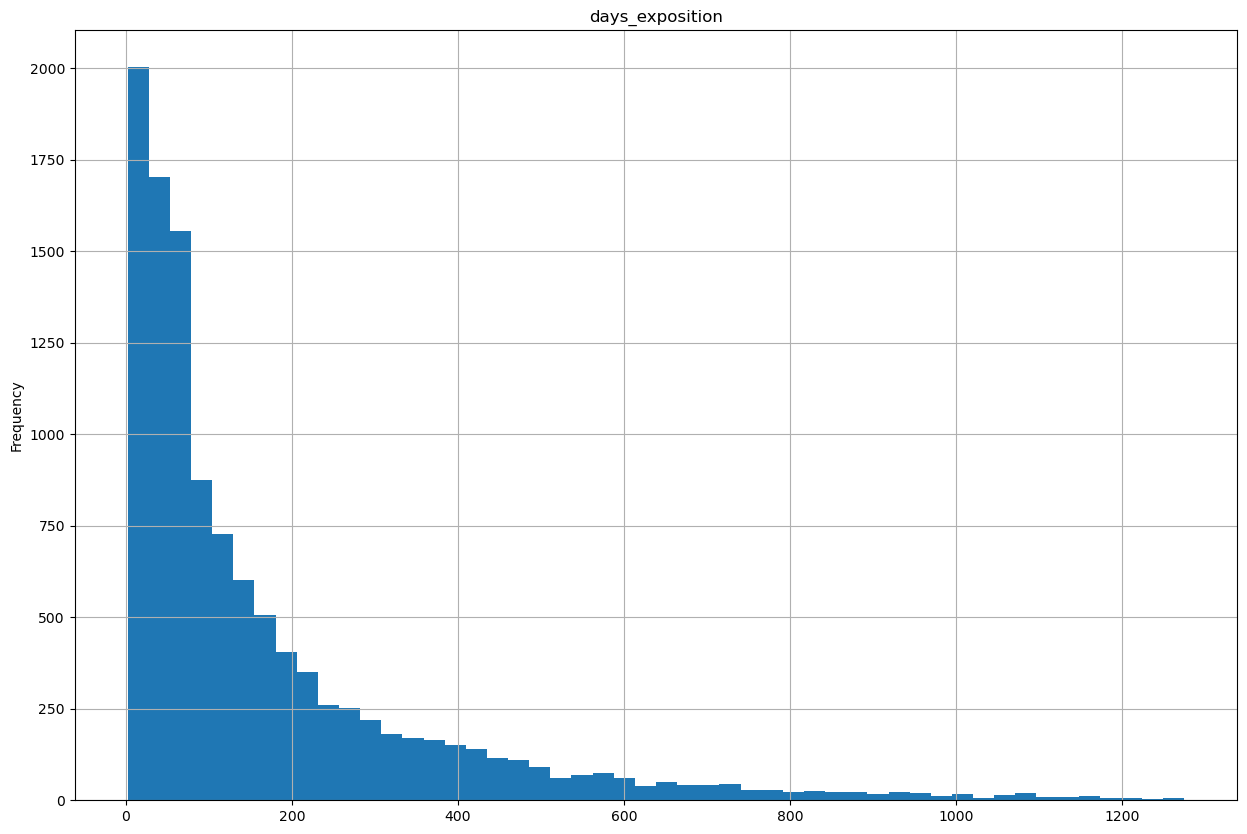

In [31]:
houses['days_exposition'].plot(kind = 'hist', bins = 50, figsize = (15,10), grid = True, title = 'days_exposition')
print('Среднее время продажи составило:', round(houses['days_exposition'].mean()), 'дня')
print('медианное время продажи составило:', round(houses['days_exposition'].median()), 'дня')
print('Количество квартир проданных за 1 квартал', houses[houses['days_exposition'] < 90]['days_exposition'].count())
print('Количество квартир проданных за 2 квартала', houses[houses['days_exposition'] < 180]['days_exposition'].count())
print('Количество квартир проданных за 1 год', houses[houses['days_exposition'] < 365]['days_exposition'].count())
print('Количество квартир проданных за 2 года', houses[houses['days_exposition'] < 730]['days_exposition'].count())
print('Количество квартир проданных за 3 квартала', houses[houses['days_exposition'] < 1095]['days_exposition'].count())

####  Большинсво квартир продаются в течении 100 дней, быстрыми можно назвать те которые продались за 74 и ниже дня, долгими я бы назвал те продажи свыше 200 дней. Видно что почти половина квартир продалась в течении 3 месяцев, а почти все остальные в течении 1 года. Видно что остались самые неликвидные квартиры которые продавались аж 3 и более лет.

Если без заполения пропусков. То получилось, что большинсво квартир продавалось в течении 100 дней размещения. Быстрыми продажами можно назвать те, которые проходили менее 80-85 дней, а долгими те продажи которые длились более 200 дней.Остальные предположения совпадают с изложенными раньше.

Корреляция цены и общей площади 76 %


<Axes: xlabel='last_price', ylabel='total_area'>

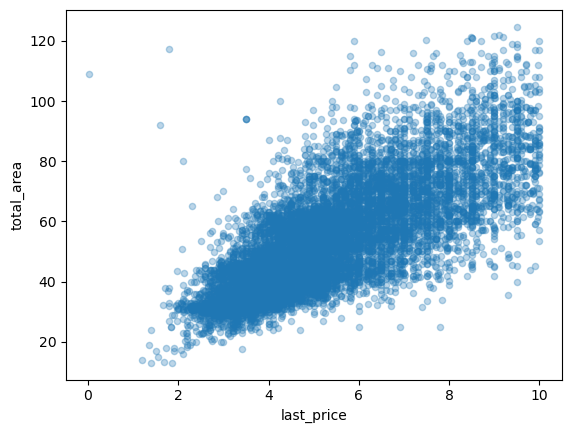

In [32]:
print('Корреляция цены и общей площади', round(houses['last_price'].corr(houses['total_area'])*100),'%')
houses.plot(x='last_price', y='total_area', kind='scatter', alpha=0.3)

Корреляция цены и жилой площади 61 %


<Axes: xlabel='last_price', ylabel='living_area'>

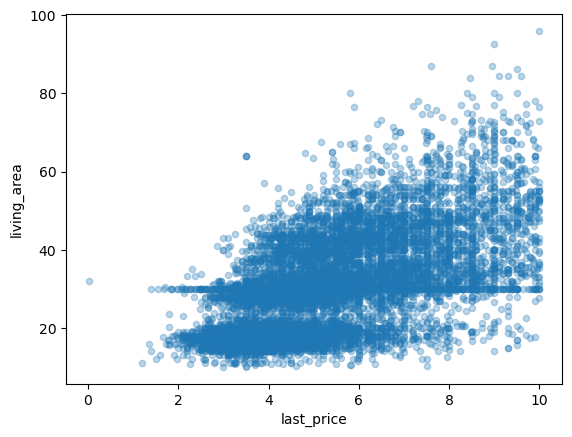

In [33]:
print('Корреляция цены и жилой площади', round(houses['last_price'].corr(houses['living_area'])*100),'%')
houses.plot(x='last_price', y='living_area', kind='scatter', alpha=0.3)

Корреляция цены и кухонной площади 44 %


<Axes: xlabel='last_price', ylabel='kitchen_area'>

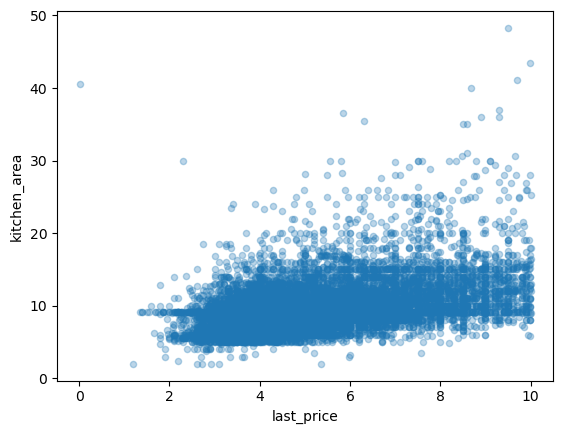

In [34]:
print('Корреляция цены и кухонной площади', round(houses['last_price'].corr(houses['kitchen_area'])*100),'%')
houses.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.3)

#### Результат довольно очевидный что цена прямо будет зависеть от размера квартиры, однако все таки для людей важнее общая плоащдь квартиры и от нее больше происходит ценообразование чем от жилой и кухонной площади.

Корреляция цены и количества комнат 52 %


<Axes: xlabel='last_price', ylabel='rooms'>

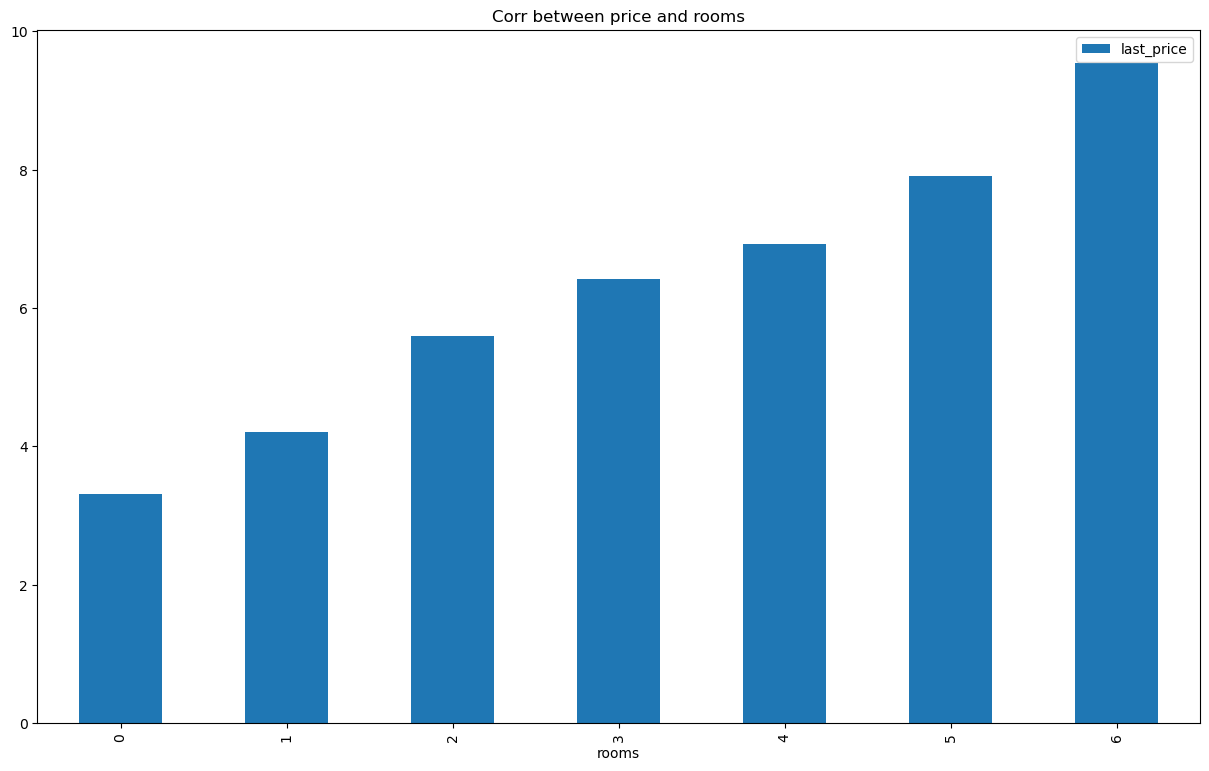

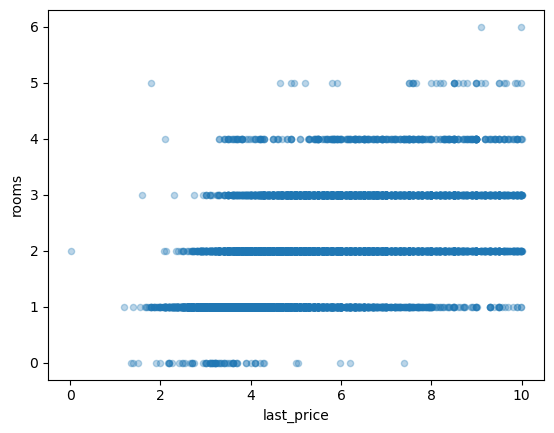

In [35]:
print('Корреляция цены и количества комнат', round(houses['last_price'].corr(houses['rooms'])*100),'%')
houses.pivot_table(index = 'rooms', values = 'last_price').plot(kind = 'bar', y = 'last_price', figsize = (15,9), title = 'Corr between price and rooms')
houses.plot(x='last_price', y='rooms', kind='scatter', alpha=0.3)


#### Корреляция присутсвует, очевидное явление что с увеличением комнат и цена на квартиру больше, так как увеличится сама площадь квартиры

<Axes: xlabel='last_price', ylabel='type_floor'>

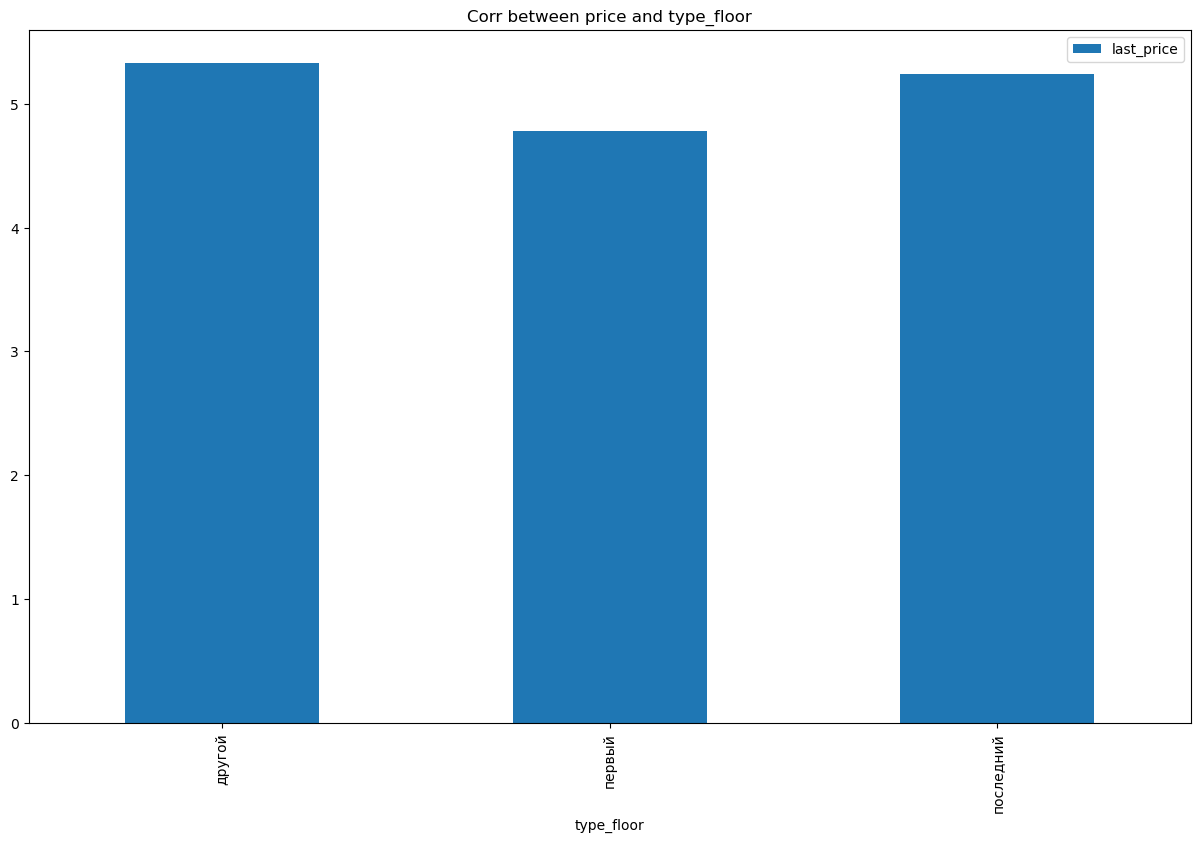

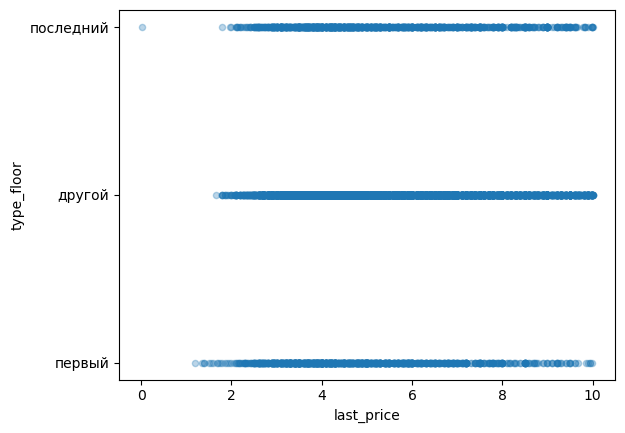

In [36]:
houses.pivot_table(index = 'type_floor', values = 'last_price').plot(kind = 'bar', y = 'last_price', figsize = (15,9), title = 'Corr between price and type_floor')
houses.plot(x='last_price', y='type_floor', kind='scatter', alpha=0.3)

####  Мне кажется присутсвует зависимость между этажом и ценой, однако графики показывают, что приблизительно одинако расположились цены на квартиры на разных этажах.По моему мнению зависимость должна быть в сторону последних этажей, обычно там квартиры стоят дороже, ну или это предположение сложилось только по Москве.

<Axes: xlabel='last_price', ylabel='week_day_of_exposition'>

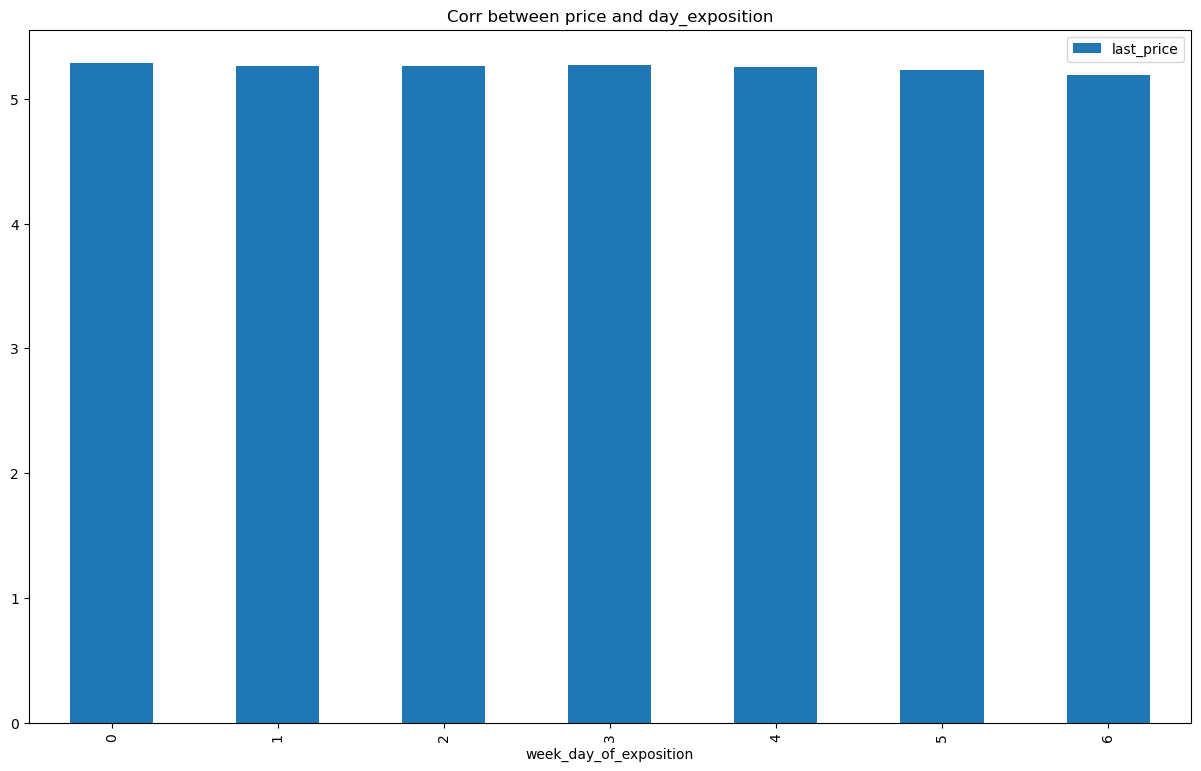

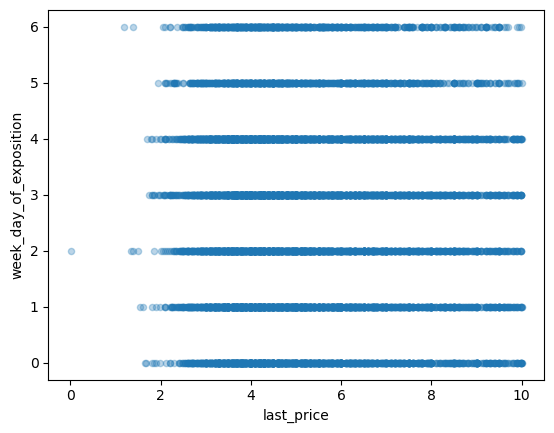

In [37]:

houses.pivot_table(index = 'week_day_of_exposition', values = 'last_price').plot(kind = 'bar', y = 'last_price', figsize = (15,9), title = 'Corr between price and day_exposition')
houses.plot(x='last_price', y='week_day_of_exposition', kind='scatter', alpha=0.3)

<Axes: xlabel='last_price', ylabel='month_of_exposition'>

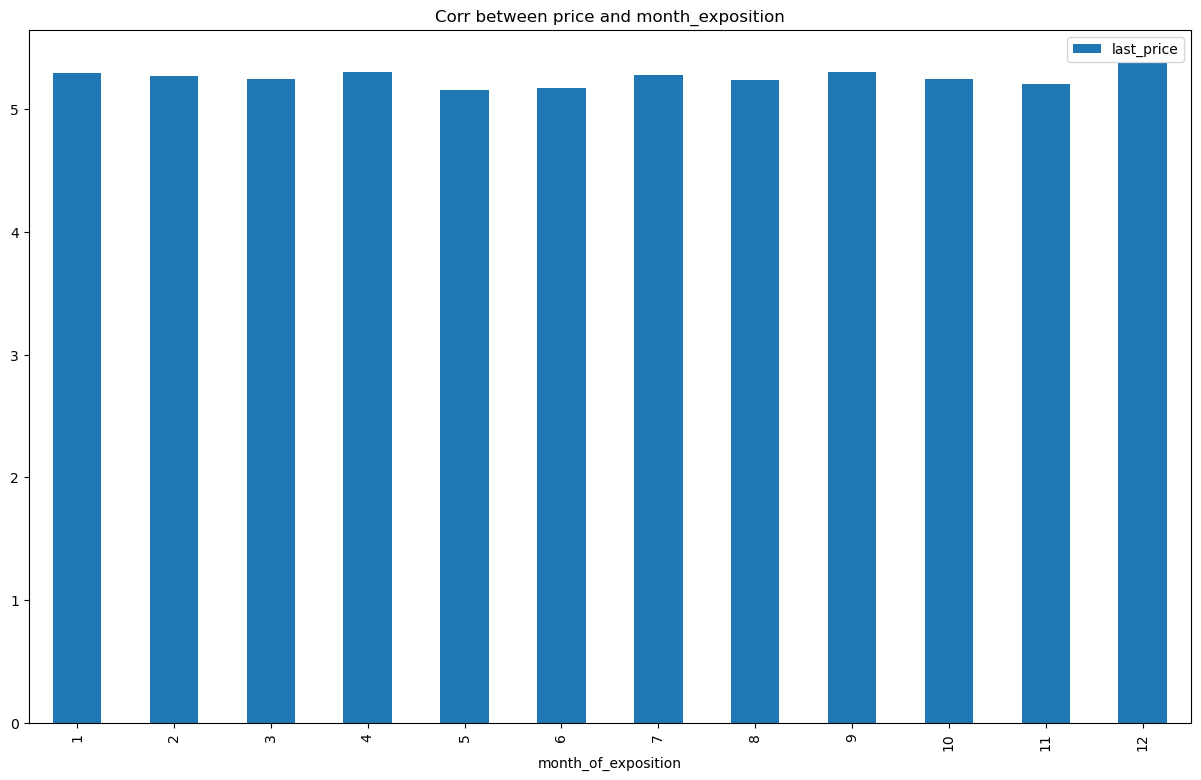

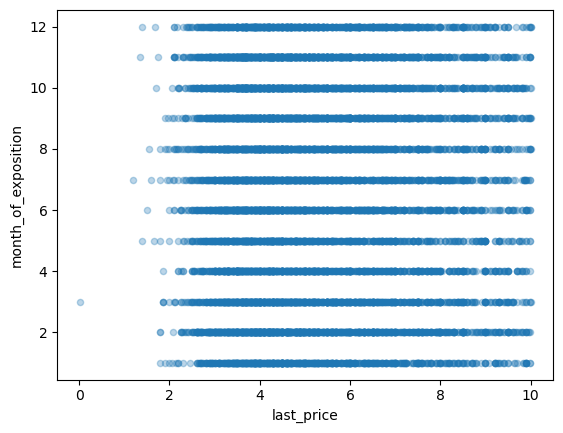

In [38]:

houses.pivot_table(index = 'month_of_exposition', values = 'last_price').plot(kind = 'bar', y = 'last_price', figsize = (15,9), title = 'Corr between price and month_exposition')
houses.plot(x='last_price', y='month_of_exposition', kind='scatter', alpha=0.3)

<Axes: xlabel='last_price', ylabel='year_of_exposition'>

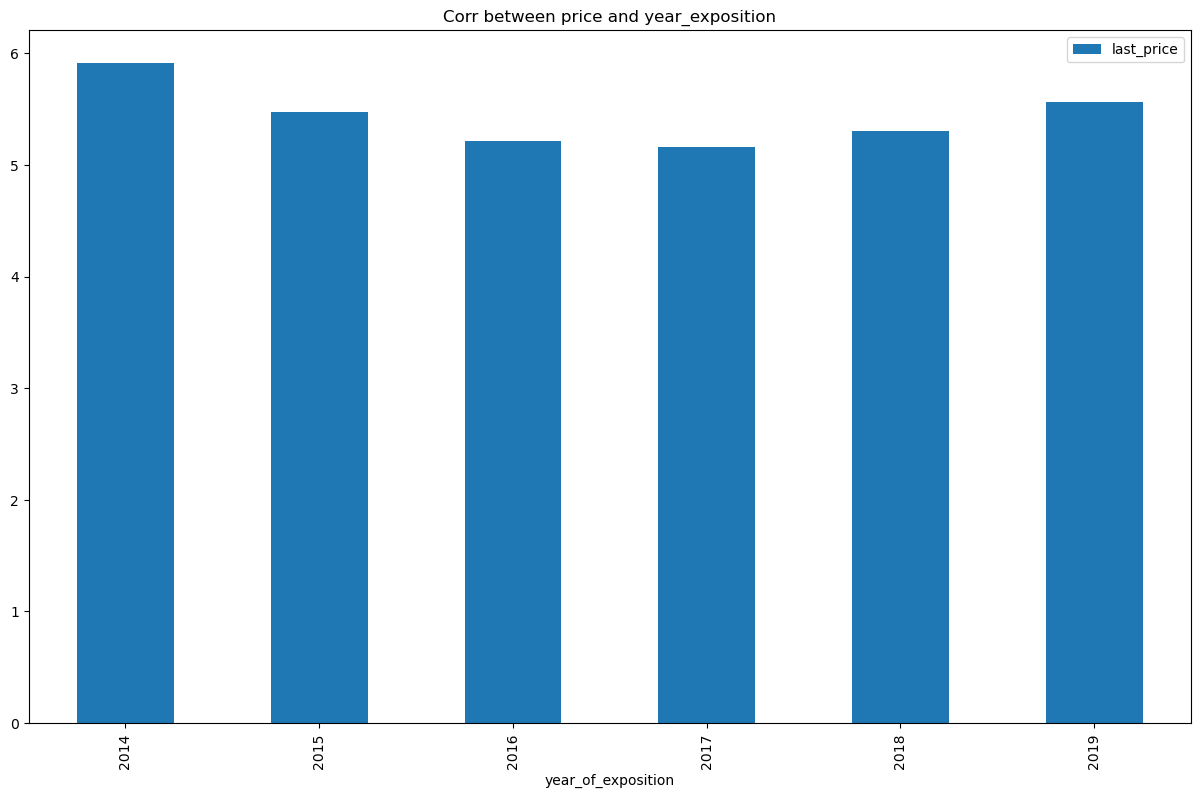

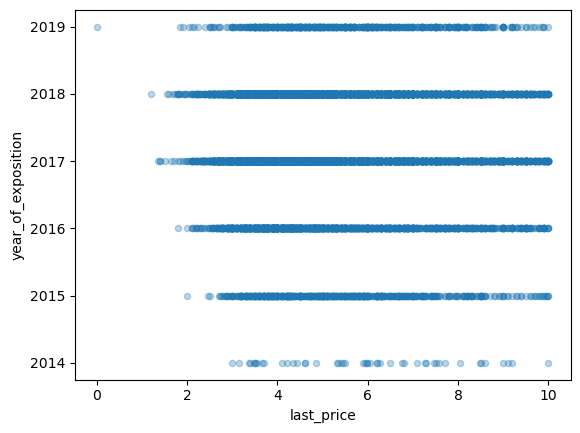

In [39]:

houses.pivot_table(index = 'year_of_exposition', values = 'last_price').plot(kind = 'bar', y = 'last_price', figsize = (15,9), title = 'Corr between price and year_exposition')
houses.plot(x='last_price', y='year_of_exposition', kind='scatter', alpha=0.3)

#### В принципе связь прослеживается, но очень тоненькая, можно предположить что в 14 году был кризис и люди решили начать продавать свое имущество, и зная то что дорогая собственность продается более 3 лет, можно предположить зависимость цены от 14 года, что в этом году она подскочила. Далее наблюдается спад, что очевидно т.к. кризисная ситуация разрешалась. В 2019 году виден рост судя по всему это связанно с подорожанием недвижимости и ростов спроса на нее.

,count,mean
locality_name,,
санкт-петербург,9679,104018.889213
поселок шушары,374,77682.514897
поселок парголово,286,89608.576736
пушкин,211,100987.537751
колпино,211,74527.635854
петергоф,133,83529.113186
красное село,125,71400.951877
сестрорецк,120,100510.408566
ломоносов,77,71068.242188


<Axes: title={'center': 'Распределение населенных пунктов по стоимости кв. м'}, xlabel='locality_name'>

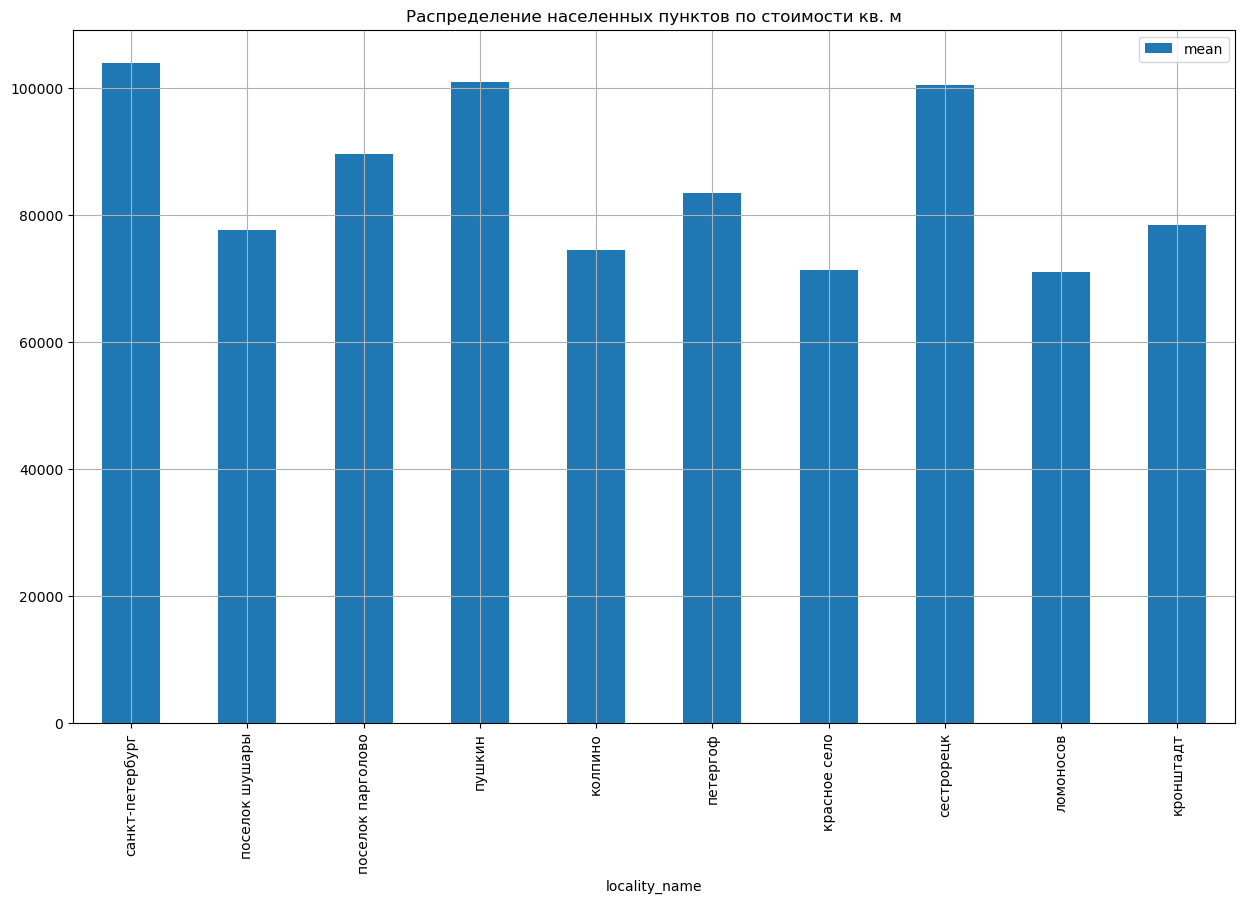

In [40]:
cities_10 =  houses.pivot_table(index = 'locality_name', values = 'cost_for_1m', aggfunc = {'count', 'mean'})
cities_10 = cities_10.sort_values(by = 'count', ascending = False)
display(cities_10.head(10))
cities_10.head(10).plot(kind = 'bar', y = 'mean', figsize = (15,9), grid = True, title = 'Распределение населенных пунктов по стоимости кв. м')

In [41]:
cities_10.sort_values(by ='mean', ascending = False).head(1)

,count,mean
locality_name,,
поселок лисий нос,2,113728.34873


#### Самым дорогим регионом является поселок лисий нос, как видно из данных всего 2 квартиры были проданы там, по достаточной большой стоимости, тут я могу предположить что это поселок элитного типа, где квартиры изначально стояли очень дорого. Тем самым он выбился вперед по стоимости относительно других. Аналогию можно привести Рублевское шоссе в Москве, где квартиры и дома продаются куда по вышей стоимости чем в самом городе.

In [42]:
cities_10.sort_values(by ='mean', ascending = True).head(1)

,count,mean
locality_name,,
поселок александровская,1,63559.322034


#### Однозначных выводов сделать сложно, лишь 1 квартира продаваль в этом населенном пункте. Видимо местоположение поселка не очень удовлетворительное, однако оно находится давольно близко к СПБ, существуют другие причины по которым цена там оказались ниже остальных.

<Axes: title={'center': 'Стоимость квартир от расстояния к центру'}, xlabel='distance_to_center_in_km'>

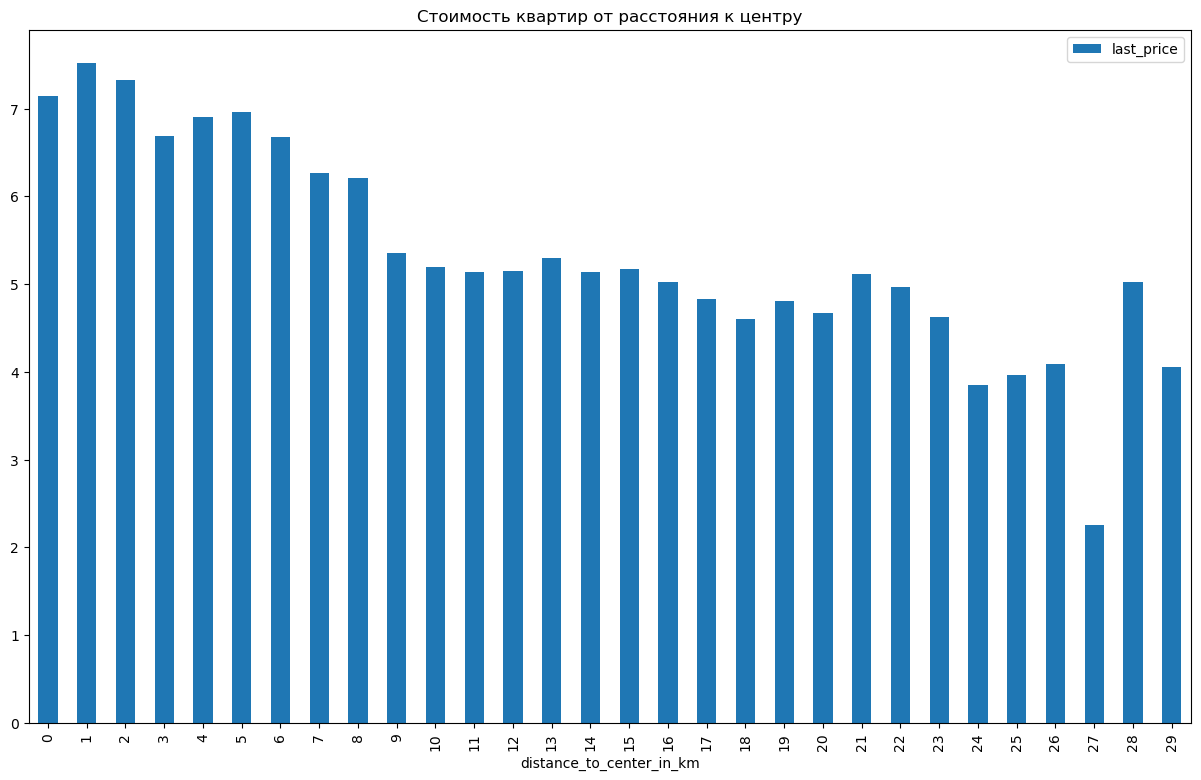

In [43]:
(
 houses[houses['locality_name'] == 'санкт-петербург']         
    .pivot_table(index = 'distance_to_center_in_km', values = 'last_price', aggfunc = 'mean')
    .plot(kind = 'bar', y = 'last_price',  figsize = (15,9), title = 'Стоимость квартир от расстояния к центру' )
)

#### Стоимость квартиры до 2 км до центра являются лидерами, это и не удивительно, в центре всегда дороже, дальше идет закономерный спат от удаления от центра. Видны расхождения на 28 и 29 км это возможно связанно с тем фактом, что строятся новые районы с хорошей инфраструктурой и "околозагородом" тем самым цена там подросла

### Общий вывод

Рассмотренная мной данные о состоянии рынка недвижимости в СПБ и прибрежных городах, позволили определить наиболее типичную квартиру, которая пользуется наибольшем спросом на рынке недвижимости ЛО. Квартила плоащадью 50-60 кв.м. В которой жилая площадь занимает 30-32 кв.м. а кухонная зона около 12 кв.м. Комнат обычно либо 1 либо 2 в такой квартире. Потолки там по стандартам и имеют высоту 2.2-2.6 м. Такая квартира скорее всего будет располагаться в доме с 5 или 9 этажами, среднестатистический дом РФ. В редких случая 25 этажный. Находится она будет около 15-17 км. от центра, при этом будет окружена водоемом и парком скорее всего. Аэропорт будет находится приблизительно в 20-25 км от квартиры, чтобы в течении часо можно было добраться. Большинсво квартир были выставленны на продажу в будние дни, связанно это с тем что такими глобальными вопросами люди хотят заниматься в рабочей обстановке, а не выходные. Видны спабы продаж в мае и январе, что обусловлено спецификой таких месяцей(новогодние праздники и отпуска). СРеднестатистическая продажаханимает порядка 90 дней, что является нормой для такого вида активов, наиболее ликвидные продаются в течении 80 дней, а наиболее неликивидные более 200 дней. Так же большиство продаваемых квартир находятся в СПБ и близких к нему, что неудивительно. Самые дорогой метр квадратный оказался в поселке лисий нос, наоборот самый дешевый в поселке александровская. Можно отметить, что на соимость квартиры очень влияет ее площадь, как общая так и жилая и кухонная. Количество комнат тоже прибавят в стоимости, ну и удаленность от центра. В центре Питера очень дорогая недвижимость